In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras import backend as K

In [2]:
Xtrain=np.loadtxt('training_data/Xtrain_inst_mask.csv',delimiter=',')
Xtest=np.loadtxt('training_data/Xtest_inst_mask.csv',delimiter=',')
Mtrain=np.loadtxt('training_data/Mtrain_inst_mask.csv',delimiter=',')
Mtest=np.loadtxt('training_data/Mtest_inst_mask.csv',delimiter=',')

#Xtest = np.array([[0 if(np.isnan(el)) else el for el in x] for x in Xtest])

Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtest=np.array([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
print(Xtrain.shape,Mtrain.shape,Xtest.shape,Mtest.shape)

(3199, 4800) (3199, 4800) (584, 4800) (584, 4800)


<function matplotlib.pyplot.show(close=None, block=None)>

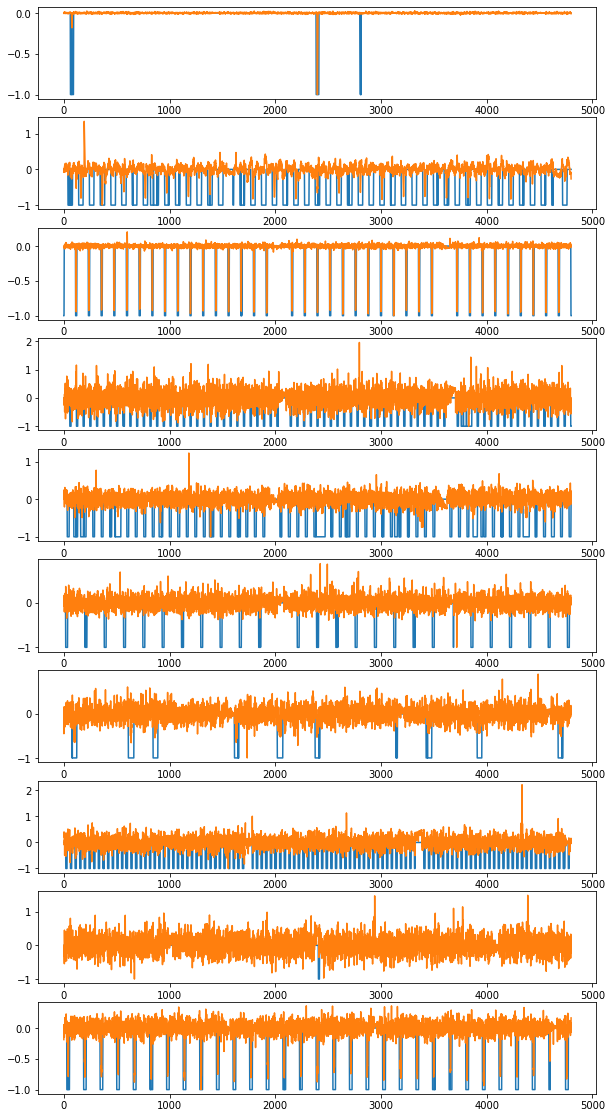

In [3]:

vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,1,figsize=(10,20))
for i in range(0,10):
    ax[i].plot(Mtrain[vararr[i]]*min(Xtrain[vararr[i]]))
    ax[i].plot(Xtrain[vararr[i]])
plt.show

In [5]:


def dice_coeff(y_true, y_pred):
    smooth = 1.
    #sh = tf.shape(y_true)
    #y_true_int = tf.reshape(y_true, [sh[0], sh[1]*sh[2]])
    #y_pred_int = tf.reshape(y_pred, [sh[0], sh[1]*sh[2]])
    #w = 1 - tf.reduce_sum(y_true,(1,2)) / 9600.
    #w = tf.reshape(w, [len(w),1])
    # Flatten
    #y_true_f = tf.reshape(tf.multiply(y_true_int,w), [-1])
    #y_pred_f = tf.reshape(tf.multiply(y_pred_int,w), [-1])
    #y_pred_f = tf.reshape(y_pred, [-1])
    #y_pred_int_f = tf.reshape(tf.matmul(w, y_pred_int), [-1])
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(Ytest,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    w=tf.cast(w,tf.float32)
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

In [6]:
IMG_SIZE=4800
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
xi=keras.layers.BatchNormalization()(xi)
x1=keras.layers.Conv1D(32,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv16_5')(xi)
c1=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(x1)    #1600

x2=keras.layers.BatchNormalization()(c1)
x2=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x2)   #size 800,16
x2=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='first_conv32_5')(x2)
c2=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(x2)

x3=keras.layers.BatchNormalization()(c2)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_2')(x3)    #size 400,32

m1=keras.layers.Conv1D(256,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(x3)
m2=keras.layers.Conv1D(256,kernel_size=3,strides=1,dilation_rate=2,activation='tanh',padding='same',name='first_conv128_5')(m1)
#m3=keras.layers.Conv1D(128,kernel_size=3,strides=1,dilation_rate=2,activation='tanh',padding='same',name='second_conv128_5')(m2)
x4 = keras.layers.Concatenate(axis=1,name='midjoin')([m1,m2])
x4=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_m')(x4)    

x4 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='tanh', padding="same", strides=2, name="decoder_conv_tran_1")(x4)
x4 =keras.layers.BatchNormalization()(x4)

x5 = keras.layers.Concatenate(axis=2)([c2,x4])
x5 = keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv32_5')(x5)
x5 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding="same", strides=2, name="decoder_conv_tran_3")(x5)
x5 = keras.layers.BatchNormalization()(x5)

x6 = keras.layers.Concatenate()([c1,x5]) #400
x6 = keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv8_5')(x6)
x6 = keras.layers.Conv1DTranspose(1,kernel_size=3,strides=2,padding='same',name='semiop',activation='sigmoid')(x6)
conv_op=keras.layers.Reshape((IMG_SIZE, ), input_shape=(IMG_SIZE,1),name='reshape_2')(x6)
keras.backend.clear_session()

convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss=bce_dice_loss)

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4800)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4800, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4800, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
second_conv16_5 (Conv1D)        (None, 2400, 32)     128         batch_normalization[0][0]        
___________________________________________________________________________________

In [7]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.asarray(Xtrain),np.asarray(Mtrain), batch_size=64, epochs=20 , verbose=1, 
     validation_split=0.15)

Epoch 1/20
43/43 [==============================] - 69s 1s/step - loss: 1.3122 - val_loss: 1.4102
Epoch 2/20
43/43 [==============================] - 59s 1s/step - loss: 1.2553 - val_loss: 1.3819
Epoch 3/20
43/43 [==============================] - 58s 1s/step - loss: 1.2189 - val_loss: 1.3347
Epoch 4/20
43/43 [==============================] - 58s 1s/step - loss: 1.1918 - val_loss: 1.2746
Epoch 5/20
43/43 [==============================] - 58s 1s/step - loss: 1.1715 - val_loss: 1.2163
Epoch 6/20
43/43 [==============================] - 58s 1s/step - loss: 1.1559 - val_loss: 1.1755
Epoch 7/20
43/43 [==============================] - 58s 1s/step - loss: 1.1410 - val_loss: 1.1452
Epoch 8/20
43/43 [==============================] - 58s 1s/step - loss: 1.1325 - val_loss: 1.1262
Epoch 9/20
43/43 [==============================] - 58s 1s/step - loss: 1.1222 - val_loss: 1.1121
Epoch 10/20
43/43 [==============================] - 58s 1s/step - loss: 1.1160 - val_loss: 1.0980
Epoch 11/20
43/43 [

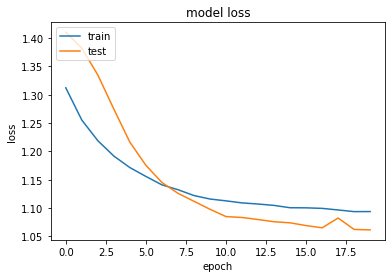

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('present_segment.png')
plt.show()

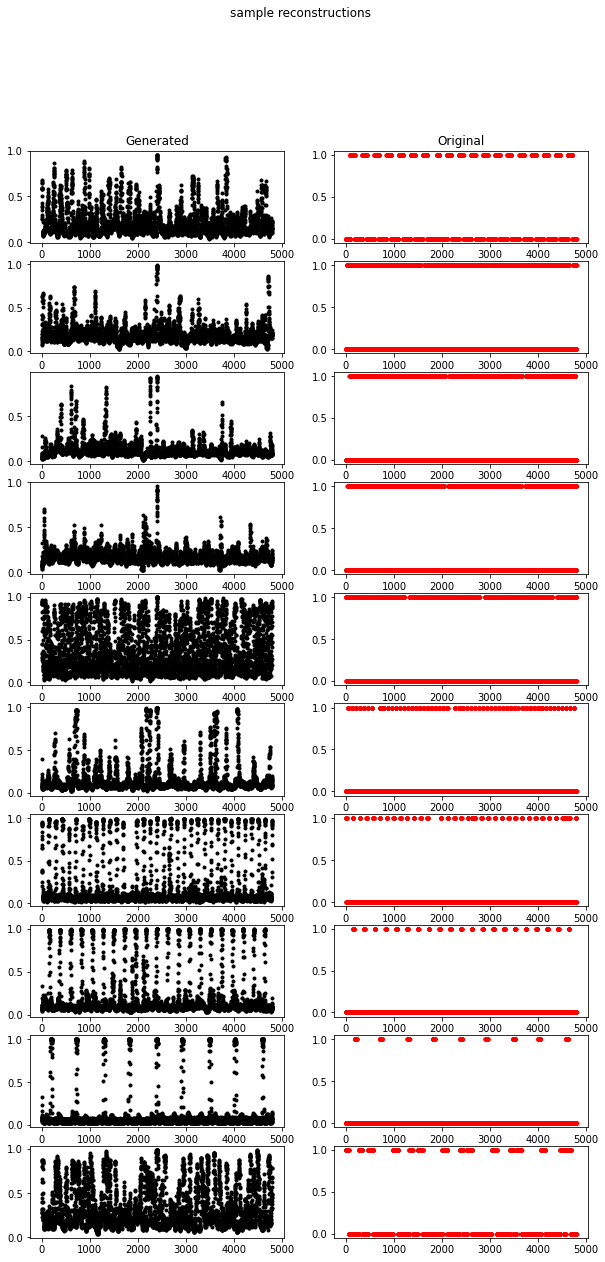

In [9]:

pred_op=convNN.predict(np.array(Xtest))

fig,ax=plt.subplots(10,2,figsize=(10,20))
plt.style.use('seaborn-bright')
plt.suptitle('sample reconstructions')
ar=np.random.randint(len(Xtest),size=10)
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,10):
    ax[i][0].plot(pred_op[ar[i]],color='black',ls='None',marker='.')
    ax[i][1].plot(Mtest[ar[i]],color='red',ls='None',marker='.')


In [40]:
X2train=np.loadtxt('training_data/X2train_inst_mask.csv',delimiter=',')
X2test=np.loadtxt('training_data/X2test_inst_mask.csv',delimiter=',')
Ytrain=np.loadtxt('training_data/Ytrain_inst_mask.csv',delimiter=',')
Ytest=np.loadtxt('training_data/Xtest_inst_mask.csv',delimiter=',')

print(X2train.shape,Ytrain.shape,X2test.shape,Ytest.shape)


(19200, 3199) (3199, 2) (19200, 584) (584, 4800)


In [41]:
X2train=np.transpose(X2train).reshape(len(Ytrain),4,4800)
X2test=np.transpose(X2test).reshape(len(Ytest),4,4800)

In [42]:
X2train=np.asarray([[(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in temp] for temp in X2train])
#X2test=np.asarray([[(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in temp] for temp in Xtest])

IndexError: invalid index to scalar variable.

In [43]:
mask_train=np.asarray([convNN.predict(el) for el in X2train])
#mask_test=np.asarray([convNN.predict(el) for el in X2test])

print(np.asarray(mask_train).shape)


(3199, 4, 4800)


In [44]:

mask_train=np.asarray([[[1 if el>0.3 else 0 for el in y]for y in x ] for x in mask_train])
#mask_test=np.asarray([[[1 if el>0.3 else 0 for el in y] for y in x ] for x in mask_test])


(3199, 4, 4800) (3199, 2) (584, 4800)


<function matplotlib.pyplot.show(close=None, block=None)>

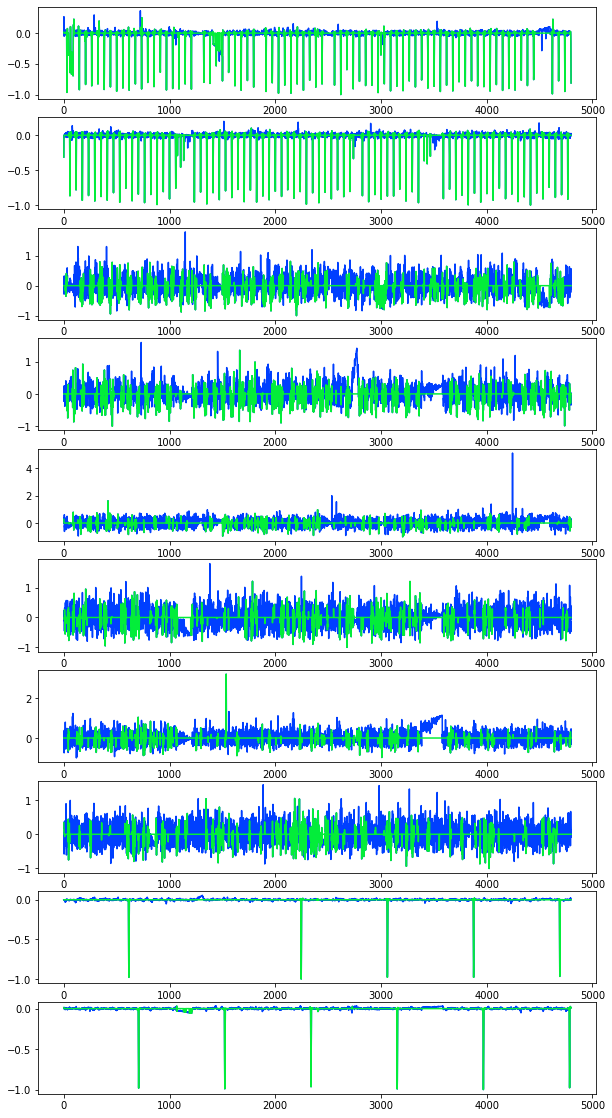

In [45]:
Itrain=np.multiply(X2train,mask_train)
#Itest=np.multiply(X2test,mask_test)


print(Itrain.shape,Ytrain.shape,Ytest.shape)
vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,1,figsize=(10,20))
for i in range(0,10,2):
    
    ax[i].plot(X2train[vararr[i],1],label=Ytrain[vararr[i]])
    ax[i].plot(Itrain[vararr[i],1],label=Ytrain[vararr[i]])
    ax[i+1].plot(X2train[vararr[i],2],label=Ytrain[vararr[i]])
    ax[i+1].plot(Itrain[vararr[i],2],label=Ytrain[vararr[i]])


plt.show

In [61]:
IM_SIZE=4800
#add hidden layers
class_ip = keras.layers.Input(shape=(IM_SIZE,4),name='Input')
m = keras.layers.Flatten()(class_ip)
m=keras.layers.Reshape((IM_SIZE*4, 1), input_shape=(IM_SIZE*4,),name='reshape_1')(m)
m=keras.layers.BatchNormalization()(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv16_5')(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv32_5')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv64_5')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_4')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_3')(m)
m=keras.layers.Flatten(name='flat_1')(m)
m=keras.layers.Dense(256,name='dense_layer_3',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(m)
m=keras.layers.Dense(1,name='dense_layer_4',activation='relu')(m)
class_op=keras.layers.Dense(2,name='dense_layer_6',activation='softmax')(m)


#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
classify = keras.Model(inputs=class_ip, outputs=class_op,name='Classifier_NN')


classify.summary()
classify.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "Classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 4800, 4)]         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 19200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 19200, 1)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 19200, 1)          4         
_________________________________________________________________
second_conv16_5 (Conv1D)     (None, 9600, 16)          64        
_________________________________________________________________
third_conv16_5 (Conv1D)      (None, 9600, 16)          784       
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 4800, 16)        

In [62]:
# Itrain=[np.transpose(el) for el in Itrain]
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history2=classify.fit(np.asarray(Itrain),np.asarray(Ytrain), batch_size=64, epochs=40 , verbose=1 , shuffle=True,validation_split=0.15)

Epoch 1/40
43/43 [==============================] - 21s 446ms/step - loss: 0.7021 - accuracy: 0.5388 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 2/40
43/43 [==============================] - 18s 416ms/step - loss: 0.7021 - accuracy: 0.5417 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 3/40
43/43 [==============================] - 18s 417ms/step - loss: 0.7020 - accuracy: 0.5417 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 4/40
43/43 [==============================] - 18s 416ms/step - loss: 0.7020 - accuracy: 0.5417 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 5/40
43/43 [==============================] - 18s 417ms/step - loss: 0.7020 - accuracy: 0.5417 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 6/40
43/43 [==============================] - 18s 417ms/step - loss: 0.7020 - accuracy: 0.5417 - val_loss: 0.7018 - val_accuracy: 0.4958
Epoch 7/40
18/43 [===========>..................] - ETA: 9s - loss: 0.7009 - accuracy: 0.5503 

KeyboardInterrupt: 

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy\n Can the NN work with the raw chunk?')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#  plt.savefig('rec_manual_mask.png')
plt.show()

In [ ]:
test_loss, test_acc = classify.evaluate(np.asarray(Itest), np.asarray(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=classify.predict(np.asarray(Itest))
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)